In [17]:
import gc
import os
import cv2
import math
import base64
import random
import numpy as np
from PIL import Image 
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.cuda import amp
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as TF
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from torchmetrics import MeanMetric

from IPython.display import display, HTML, clear_output


## Helper functions

In [45]:
def to_device(data, device):
    """将张量移动到选择的设备"""
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [19]:
class DeviceDataLoader:
    """包装一个数据加载器，来把数据移动到另一个设备上"""
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """在移动到设备后生成一个批次的数据"""
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """批次的数量"""
        """Number of batches"""
        return len(self.dl)

In [20]:
def get_default_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
def save_images(images, path, **kwargs):
    grid = make_grid(images, **kwargs)
    ndarr = grid.permute(1,2,0).to("cpu").numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [22]:
def get(element: torch.Tensor, t: torch.Tensor):
    """
    Get value at index position "t" in "element" and 
        reshape it to have the same dimension as a batch of images

    获得在"element"中位置"t"并且reshape，以和一组照片有相同的维度
    """
    ele = element.gather(-1, t)
    return ele.reshape(-1, 1, 1, 1)

In [23]:
element = torch.tensor([[1,2,3,4,5],
                        [2,3,4,5,6],
                        [3,4,5,6,7]])
t = torch.tensor([1,2,0]).unsqueeze(1)

In [24]:
print(element)
print(t)

tensor([[1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]])
tensor([[1],
        [2],
        [0]])


In [25]:
extracted_scores = get(element, t)
print(extracted_scores)

tensor([[[[2]]],


        [[[4]]],


        [[[3]]]])


In [26]:
def setup_log_directory(config):
    """
    Log and Model checkpoint directory Setup
    记录并且建模目录准备
    """

    if os.path.isdir(config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        # 在root_log_dir下获得所有文件夹数目
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(config.root_log_dir)]

        # Find the latest version number present in the log_dir
        # 找到在log_dir下的最新版本数字
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version{last_version_number + 1}"

    else:
        version_name = config.log_dir

    # Update the training config default directory
    # 更新训练config默认目录
    log_dir         = os.path.join(config.root_log_dir,         version_name)
    checkpoint_dir  = os.path.join(config.root_checkpoint_dir,  version_name) 

    # Create new directory for saving new experiment version
    # 创建一个新目录来保存新的实验版本
    os.makedirs(log_dir,        exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")
    print(f"Model Checkpoint at: {checkpoint_dir}")

    return log_dir, checkpoint_dir


In [28]:
def frames2vid(images, save_path):

    WIDTH = images[0].shape[1]
    HEIGHT = images[0].shape[0]

    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(save_path, fourcc, 25, (WIDTH, HEIGHT))

    # Appending the images to the video one by one
    # 一个接一个的将照片追加到视频
    for image in images:
        video.write(image)
    
    # Deallocating memories taken for window creation
    # 释放创建window占用的内存
        
    video.release()
    return

def display_gif(gif_path):
    b64 = base64.b64encode(open(gif_path,'rb').read()).decode('ascii')
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))


## Configurations

In [29]:
from dataclasses import dataclass

@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "Flowers" #MNIST "cifar-10" "Flowers"

    # 记录推断日志信息并保存存档点
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints","checkpoints")

    #目前的日志和存档点目录
    log_dir = "version_0"
    checkpoint_dir = "version_0"

@dataclass
class TrainingConfig:
    TIMESTEPS = 1000
    IMG_SHAPE = (1,32,32) if BaseConfig.DATASET == "MNIST" else (3,32,32)
    NUM_EPOCHS = 800
    BATCH_SIZE = 32
    LR = 2e-4
    NUM_WORKERS = 2

## Load Dataset & Build Dataloader

In [38]:
def get_dataset(dataset_name='MNIST'):
    """
    Returns the dataset class object that will be passed to the Dataloader
    Three preprocessing transforms,
    and one augmentation are applied to every image in the dataset
    返回数据集的类对象
    这个类对象将会被传递给DataLoader
    数据集中的每个图象将会应用三个预处理转换
    和一个增强
    """
    transforms = TF.Compose(
        [
            TF.ToTensor(),
            TF.Resize((32,32),
                      interpolation=TF.InterpolationMode.BICUBIC,
                      antialias=True),
            TF.RandomHorizontalFlip(),
            TF.Lambda(lambda t: (t * 2) - 1) # scale between [-1, 1]
        ]
    )

    if dataset_name.upper() == "MNIST":
        dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms)
    elif dataset_name == "Cifar-10":
        dataset = datasets.CIFAR10(root="data", train=True,download=True, transform=transforms)
    elif dataset_name == "Cifar-100":
        dataset = datasets.CIFAR10(root="data", train=True,download=True, transform=transforms)
    elif dataset_name == "Flowers":
        dataset = datasets.ImageFolder(root="data/flowers", transform=transforms)
    return dataset

In [40]:
def get_dataloader(dataset_name='MNIST',
                   batch_size=32,
                   pin_memory=False,
                   shuffle=True,
                   num_workers=0,
                   device="cpu"
                   ):
    dataset     = get_dataset(dataset_name=dataset_name)
    dataLoader  = DataLoader(dataset, batch_size=batch_size,
                             pin_memory=pin_memory,
                             num_workers=num_workers,
                             shuffle=shuffle
                             )
    device_dataloader = DeviceDataLoader(dataLoader, device)
    return device_dataloader

In [41]:
def inverse_transform(tensors):
    """
    Convert tensors from [-1., 1.] to [0., 255.]
    """
    return ((tensors.clamp(-1, 1) + 1.0) / 2.0) * 255.0

In [39]:
dataset = get_dataset(dataset_name='Flowers')
print(dataset)

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: data/flowers
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bicubic, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               Lambda()
           )


## Visualize Dataset

In [43]:
loader = get_dataloader(
    dataset_name=BaseConfig.DATASET,
    batch_size=128,
    device='cpu'
)

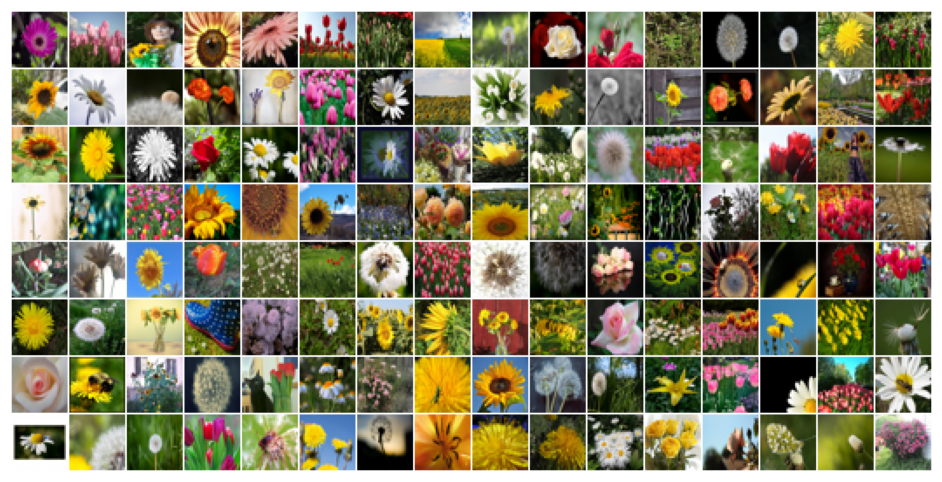

In [46]:
plt.figure(figsize=(12, 6), facecolor='white')

for b_image, _ in loader:
    b_image = inverse_transform(b_image).cpu()
    grid_img = make_grid(b_image / 255.0, 
                         nrow = 16, 
                         padding=True,
                         pad_value=1,
                         normalize=True 
                        )
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis("off")
    break